# Learning Weights for the Draco Model

In this example, we are using a linear SVM model to learn weights for a Draco model. The input to the model are pairs of visualizations where one visualization is preferred to another. We then try to find weights such that most of the pairs are correctly classified. Each visualization is represented as a vector of number of violations.

Given pairs of preferred (postiive) $\lbrack u_1, u_2, ..., u_k \rbrack$ and a not preferred (negative) $\lbrack v_1, v_2, ..., v_k \rbrack$ visualization, we try to maximize the distance between these vectors using ${\arg\max}_w \sum_{i\, \in\, 0...k} w_i \, (u_i-v_i)$. To implement this loss, we subtract the positive and negaitve vectors and learn weights using a linear SVM with one class.

In [1]:
import json
import pandas as pd
from typing import Dict, List, Any
from sklearn.model_selection import train_test_split

from draco import Draco

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.decomposition import PCA

In [2]:
default_draco = Draco()

In [3]:
def get_nested_index(fields=None):
    """
    Gives you a nested pandas index that we apply to the data when creating a dataframe.
    """
    features = default_draco.soft_constraint_names

    iterables = [fields or ["negative", "positive"], features]
    index = pd.MultiIndex.from_product(iterables, names=["category", "feature"])
    index = index.append(pd.MultiIndex.from_arrays([["source", "task"], ["", ""]]))
    return index

In [4]:
def pairs_to_vec(specs: Dict[str, Dict[str, List]]) -> pd.DataFrame:
    """given specs, convert them into feature vectors."""

    columns = get_nested_index()
    dfs: List[pd.DataFrame] = []

    for example in specs.values():
        neg_feature_vec = default_draco.count_preferences(
            example["data"] + example["negative"]
        )
        pos_feature_vec = default_draco.count_preferences(
            example["data"] + example["positive"]
        )

        assert neg_feature_vec is not None
        assert pos_feature_vec is not None

        feature_vecs: Dict[Any, Any] = {}
        feature_vecs = {
            ("negative", key): values for key, values in neg_feature_vec.items()
        }
        feature_vecs.update(
            {("positive", key): values for key, values in pos_feature_vec.items()}
        )

        feature_vecs[("source", "")] = example["source"]
        feature_vecs[("task", "")] = example["task"]

        dfs.append(
            pd.DataFrame(feature_vecs, columns=columns, index=[example["pair_id"]])
        )

    return pd.concat(dfs).fillna(0)

In [5]:
def train_model(X: pd.DataFrame, test_size: float = 0.3, C: float = 1, quiet=False):
    """Given features X and labels y, train a linear model to classify them
    Args:
        X: a N x M matrix, representing feature vectors
        y: a N vector, representing labels
        test_size: the fraction of test data
    """

    X_train, X_dev = train_test_split(X, test_size=test_size, random_state=1)

    size = len(X_train)

    y_train = np.ones(size)

    # flip a few examples at random
    idx = np.ones(size, dtype=bool)
    idx[: int(size / 2)] = False
    np.random.shuffle(idx)

    X_train[idx] = -X_train[idx]
    y_train[idx] = -y_train[idx]

    clf = svm.LinearSVC(C=C, fit_intercept=False)
    clf.fit(X_train, y_train)

    if not quiet:
        print("Train score: ", clf.score(X_train, y_train))
        if test_size > 0:
            print("Dev score: ", clf.score(X_dev, np.ones(len(X_dev))))

    return clf


def train_and_plot(data: pd.DataFrame, test_size: float = 0.3):
    """use SVM to classify them and then plot them after projecting X, y into 2D using PCA"""
    X = data.negative - data.positive

    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    clf = train_model(X, test_size)

    # for plotting
    X0, X1 = X2[:, 0], X2[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    f, ax = plt.subplots(figsize=(8, 6))

    # predictions made by the model
    pred = clf.predict(X)

    correct = pred > 0

    plt.scatter(
        X0[correct],
        X1[correct],
        c="g",
        cmap=cm_bright,
        alpha=0.5,
        marker=">",
        label="correct",
    )
    plt.scatter(
        X0[~correct],
        X1[~correct],
        c="r",
        cmap=cm_bright,
        alpha=0.5,
        marker="<",
        label="incorrect",
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_xlabel("X0")
    ax.set_ylabel("X1")

    ax.set_xticks(())
    ax.set_yticks(())

    plt.title("Predictions of Linear Model")

    plt.annotate(
        f"Score: {clf.score(X, np.ones(len(X))):.{5}}. N: {int(len(data))}",
        (0, 0),
        (0, -20),
        xycoords="axes fraction",
        textcoords="offset points",
        va="top",
    )

    plt.legend(loc="lower right")
    plt.axis("tight")

    plt.show()

    return clf


def project_and_plot(data: pd.DataFrame, test_size: float = 0.3):
    """Reduce X, y into 2D using PCA and use SVM to classify them
    Then plot the decision boundary as well as raw data points
    """
    X = data.negative - data.positive

    pca = PCA(n_components=2)
    X = pca.fit_transform(X)

    clf = train_model(X, test_size)

    # for plotting
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    f, ax = plt.subplots(figsize=(8, 6))

    plot_contours(ax, clf, xx, yy)

    # predictions made by the model
    pred = clf.predict(X)

    correct = pred > 0

    plt.scatter(
        X0[correct],
        X1[correct],
        c="g",
        cmap=cm_bright,
        alpha=0.5,
        marker=">",
        label="correct",
    )
    plt.scatter(
        X0[~correct],
        X1[~correct],
        c="r",
        cmap=cm_bright,
        alpha=0.5,
        marker="<",
        label="incorrect",
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_xlabel("X0")
    ax.set_ylabel("X1")

    ax.set_xticks(())
    ax.set_yticks(())

    plt.title("Predictions of Linear Model")

    plt.annotate(
        f"Score: {clf.score(X, np.ones(len(X))):.{5}}. N: {int(len(data))}",
        (0, 0),
        (0, -20),
        xycoords="axes fraction",
        textcoords="offset points",
        va="top",
    )

    plt.legend(loc="lower right")
    plt.axis("tight")

    plt.show()

    return clf


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Params:
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def make_meshgrid(x, y, h=0.01):
    """Create a mesh of points to plot in
    Params:
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional
    Returns:
        xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [6]:
kim_data = {}

with open("./data/kim2018_draco2.json") as file:
    i = 0
    json_data = json.load(file)

    for pair in json_data:
        pair["pair_id"] = i
        pair["source"] = "kim_2018"
        kim_data[i] = pair
        i += 1

data = pairs_to_vec(kim_data)

assert set(data.negative.columns) == set(
    default_draco.soft_constraint_names
), "Feature names do not match."

In [7]:
train_dev, _ = train_test_split(data, test_size=0.3, random_state=1)

Train score:  0.49822695035460995
Dev score:  0.4834710743801653


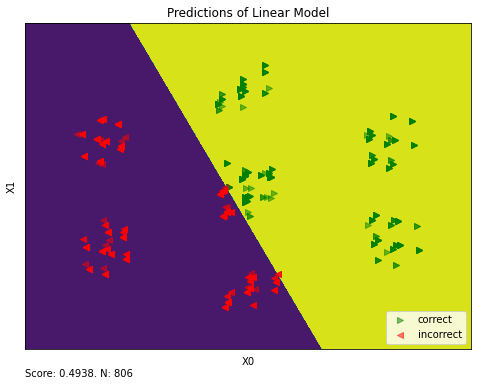

LinearSVC(C=1, fit_intercept=False)

In [8]:
project_and_plot(train_dev, test_size=0.3)

Train score:  0.925531914893617
Dev score:  0.9090909090909091


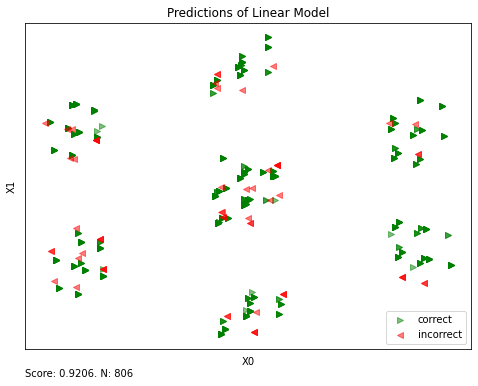

#const aggregate_weight = 0.

#const aggregate_count_weight = 0.

#const aggregate_group_by_raw_weight = 0.

#const aggregate_max_weight = 0.

#const aggregate_mean_weight = 0.

#const aggregate_median_weight = 0.

#const aggregate_min_weight = 0.

#const aggregate_no_discrete_weight = 0.

#const aggregate_stdev_weight = 0.

#const aggregate_sum_weight = 0.

#const bin_weight = 0.

#const bin_high_weight = 0.

#const bin_low_weight = 0.

#const bin_low_unique_weight = 0.

#const bin_not_linear_weight = 0.

#const binned_orientation_not_x_weight = 0.

#const c_c_area_weight = 0.

#const c_c_line_weight = 0.

#const c_c_point_weight = -56.

#const c_c_text_weight = 0.

#const c_d_area_weight = 0.

#const c_d_bar_weight = 0.

#const c_d_col_weight = 0.

#const c_d_line_weight = 0.

#const c_d_no_overlap_area_weight = 0.

#const c_d_no_overlap_bar_weight = 0.

#const c_d_no_overlap_line_weight = 0.

#const c_d_no_overlap_point_weight = 0.

#const c_d_no_overlap_text_weight = 0.

#const c_d

In [9]:
clf = train_and_plot(train_dev, test_size=0.3)

features = train_dev.negative.columns

for feature, weight in zip(features, clf.coef_[0]):
    print(f"#const {feature}_weight = {int(weight * 1000)}.\n")